# Loading the lattice

The central object in Pytac is the `lattice`. It holds the information about all of the elements in the accelerator.

All the data about the lattice and its elements is stored in CSV files inside the Pytac repository. We use the `load_csv` module to load the data and initialise a `lattice` object; this is the normal starting point for using Pytac.

First some required imports:

In [1]:
import pytac
import atip
import cothread
from matplotlib import pyplot as plt

Let's load the `"DIAD"` ring mode lattice with Pytac. The "ring mode" describes one configuration of the `elements` in the `lattice`. There is one set of `.csv` files for each ring mode. So when we load the lattice, we specify the ring mode we want to load:

In [13]:
lattice = pytac.load_csv.load("DIAD")

The `lattice` object itself has some `fields` with its own properties:

In [3]:
print(lattice.get_fields())
print(lattice.get_value("energy"))
print(lattice.get_value("beam_current"))

{'live': dict_keys(['beam_current', 'emittance_x', 'emittance_y', 'tune_x', 'tune_y', 's_position', 'energy'])}
3000000000.0
301.1515034398837


The name `"live"` refers to the data source, in this case, the live machine; Pytac can also be set up with additional data sources for simulation, so let's do that. We use atip to load a PyAT simulation, based on our `.mat` AT lattice file, onto our Pytac lattice as a `"simulation"` data source:

In [14]:
lattice = atip.load_sim.load_from_filepath(lattice, "atip/rings/DIAD.mat")

Let's check the fields again:

In [5]:
print(lattice.get_fields())

{'live': dict_keys(['beam_current', 'emittance_x', 'emittance_y', 'tune_x', 'tune_y', 's_position', 'energy']), 'simulation': ['chromaticity_x', 'chromaticity_y', 'chromaticity', 'eta_prime_x', 'eta_prime_y', 'dispersion', 'emittance_x', 'emittance_y', 'emittance', 'closed_orbit', 'eta_x', 'eta_y', 'energy', 'phase_x', 'phase_y', 's_position', 'tune_x', 'tune_y', 'alpha', 'beta', 'tune', 'm66', 'x', 'y', 'mu']}


## Using the Simulated Data Source

Now that we've loaded the simulator onto the lattice, let's see how to use it. First let's get the `"x"` values for all the `BPMs` in the lattice for the live machine:

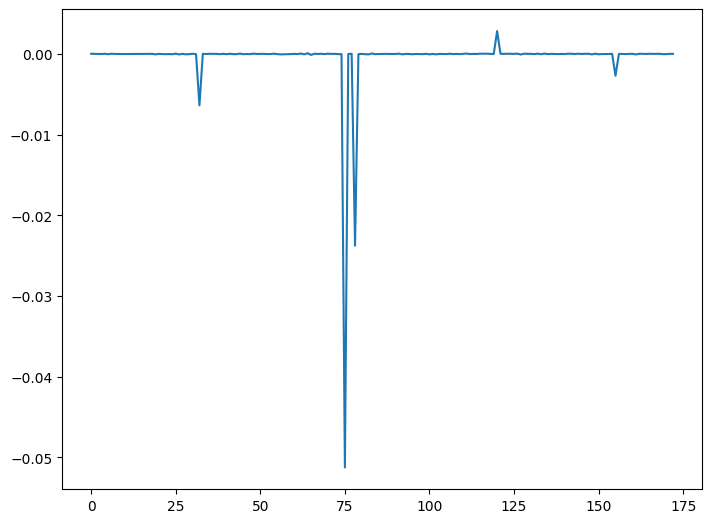

In [6]:
bpms = lattice.get_elements('BPM')
#print(cothread.catools.caget("SR02C-DI-EBPM-05:SA:X"))
x_values = []
for bpm in bpms:
    x_values.append(bpm.get_value("x", data_source=pytac.LIVE))
#print(x_values)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(range(len(bpms)), x_values)
plt.show()

Now let's set the data source to the simulator and try that:

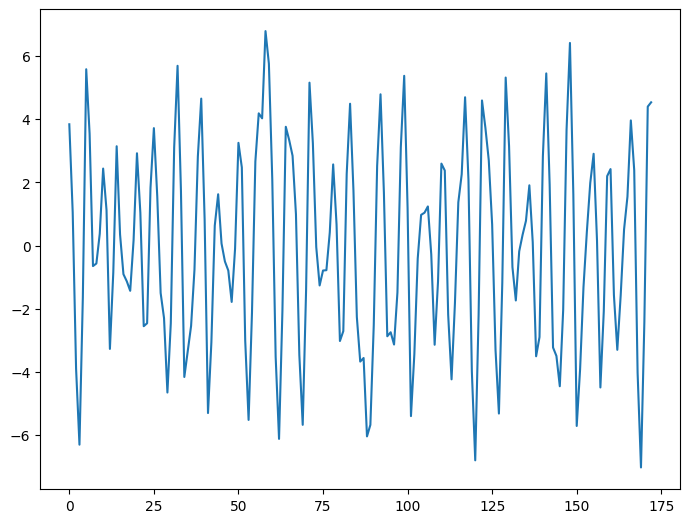

In [18]:
initial_x_values = []
for bpm in bpms:
    initial_x_values.append(bpm.get_value("x", data_source=pytac.SIM))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(range(len(bpms)), initial_x_values)
plt.show()

Now let's change one of the correctors and see what happens:

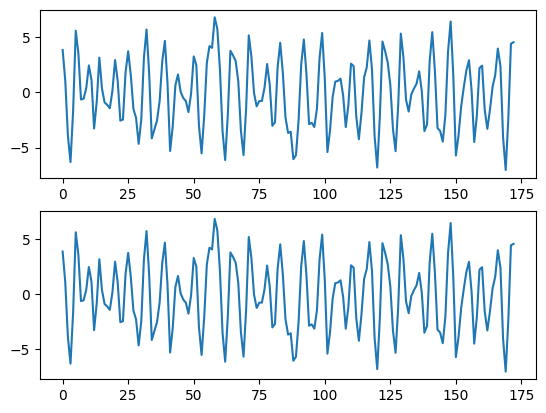

In [19]:
# Display our initial BPM x positions for reference
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(range(len(bpms)), initial_x_values)
# Change the x_kick of one of the corrector magnets
hcor1 = lattice.get_elements("HSTR")[10]
simulator = atip.utils.get_atsim(lattice)
hcor1.set_value("x_kick", 0.001, units=pytac.PHYS, data_source=pytac.SIM)
simulator.wait_for_calculations()
# Measure and plot the BPM x positions after the change
new_x_values = []
for bpm in bpms:
    new_x_values.append(bpm.get_value("x", data_source=pytac.SIM))
ax2 = fig.add_subplot(2,1,2)
ax2.plot(range(len(bpms)), new_x_values)
plt.show()

## Devices

Each field has a `device` object associated with it, which knows how to set and get the value.

In [10]:
one_bpm.get_device("x")

The `device` object knows the PV names for reading and writing the value of the field. Each field might have a "setpoint" or "readback" handle, which could be associated with different PV names.

You can use either strings or pytac constants to specify which handle to use. 

In [11]:
readback_pv = one_bpm.get_pv_name("x_sofb_disabled", "readback")
same_readback_pv = one_bpm.get_pv_name("x_sofb_disabled", pytac.RB)
print(readback_pv, same_readback_pv)

('SR01C-PC-HBPM-01:SLOW:DISABLED', 'SR01C-PC-HBPM-01:SLOW:DISABLED')


Some fields are read-only, in which case there is no setpoint PV to get.

In [12]:
try:
    one_bpm.get_pv_name("x_sofb_disabled", pytac.SP)
except Exception as e:
    print(e)

Device SR01C-DI-EBPM-01 has no setpoint PV.


It's not normally necessary to interact with the `device` directly; you can do most things through methods of the `element` or `lattice`. E.g. element.get_value() above and `lattice.get_element_pv_names`:

In [13]:
lattice.get_element_pv_names('BPM', 'y', 'readback')[:10]

['SR01C-DI-EBPM-01:SA:Y',
 'SR01C-DI-EBPM-02:SA:Y',
 'SR01C-DI-EBPM-03:SA:Y',
 'SR01C-DI-EBPM-04:SA:Y',
 'SR01C-DI-EBPM-05:SA:Y',
 'SR01C-DI-EBPM-06:SA:Y',
 'SR01C-DI-EBPM-07:SA:Y',
 'SR02C-DI-EBPM-01:SA:Y',
 'SR02C-DI-EBPM-02:SA:Y',
 'SR02C-DI-EBPM-03:SA:Y']

## Unit conversions

Many fields can be represented in either engineering units or physics units. For example, for a magnet field, the physics unit would be the field strength and the engineering unit would be the current applied by the magnet power supply controller.

In [14]:
# Get a corrector magnet
corrector = lattice.get_elements("HSTR")[5]
# Request
corrector.get_value("x_kick", units=pytac.ENG)

-3.0552401542663574

In order to get the unit itslef, we have to ask for the `unitconv` object associated with the field.

In [15]:
corrector.get_unitconv("x_kick").eng_units

'A'

## Magnet fields

This seems like a good time to talk about the names for the magnetic fields of magnets.

In accelerator physics we refer to the different components of magnetic fields as $a_n$ for vertical fields and $b_n$ for horizontal fields, where n is:

| n   | Field      |
|-----|------------|
| 0   | Dipole     |
| 1   | Quadrupole |
| 2   | Sextupole  |
| ... | ...        |

These names are used for the `field`s associated with magnet `element`s in pytac.

For corrector magnets, although the corrector field acts like a dipole, it is given the name `x_kick` or `y_kick` so that it can be easily distinguished. An example of this is when several magnets are combined into the same `element`. The following example shows an element which combines a corrector, a skew quadrupole and a sextupole.

In [16]:
an_element = lattice.get_elements("HSTR")[12]
print("Fields:", an_element.get_fields())
print("Families:", an_element.families)

('Fields:', {'live': ['h_fofb_disabled', 'h_sofb_disabled', 'v_fofb_disabled', 'a1', 'x_kick', 'v_sofb_disabled', 'b2', 'y_kick']})
('Families:', set(['S4E', 'SQUAD', 'SEXT', 'VSTR', 'HSTR']))


## Other methods of the `lattice`

To finish off for now, let's look at some more of the methods of the `lattice`

`lattice.get_element_values` lets you get all the live values for a field from a while family of elements. E.g. the currents for the horizontal corrector magnets. There is also an analogous command `lattice.set_element_values()`.

In [17]:
lattice.get_element_values("HSTR", "x_kick", "readback")

[-0.24839822947978973,
 0.7639292478561401,
 -0.4572945237159729,
 -0.1370551735162735,
 0.6560376882553101,
 -3.0552401542663574,
 3.0576119422912598,
 0.6859914660453796,
 -0.8835821747779846,
 0.37336450815200806,
 -0.397186279296875,
 -0.3592968285083771,
 1.5479310750961304,
 -0.2497788667678833,
 -0.3833305537700653,
 0.04267336428165436,
 0.387008398771286,
 2.083509922027588,
 -2.213555335998535,
 2.316075086593628,
 -1.2140284776687622,
 0.4225691556930542,
 -0.3863433301448822,
 0.1559593677520752,
 2.3147804737091064,
 -0.2917431592941284,
 -1.003007173538208,
 0.5435793995857239,
 -0.21308128535747528,
 0.30097678303718567,
 0.42939627170562744,
 2.6342201232910156,
 -3.1828463077545166,
 1.8283201456069946,
 -0.6628888845443726,
 0.1967700868844986,
 -0.15570154786109924,
 -0.08124255388975143,
 -0.09838544577360153,
 1.190570592880249,
 -0.9167197346687317,
 -1.0333651304244995,
 0.20847293734550476,
 -0.26976802945137024,
 0.3439919054508209,
 1.0685083866119385,
 -0.269

`s` position is the position of an element in metres around the ring.

There is a method to get the `s` positions of all elements in a family:

In [18]:
lattice.get_family_s("BPM")[:10]

[4.38,
 8.806500000000002,
 11.374000000000002,
 12.559000000000005,
 14.942500000000006,
 18.005000000000003,
 21.270000000000003,
 26.93,
 30.360759,
 32.076129]